# Uma Implementação Adaboost com Decision Stumps

O AdaBoost é um algoritmo de aprendizado supervisionado do tipo boosting. O AdaBoost combina um conjunto de funções simples de classificação, denominadas classificadores fracos para formar um classificador forte.

Um classificador forte é composto de um conjunto de classificadores fracos, associados a pesos que classificam de forma precisa  conjuntos de dados pré-rotulados, onde as características com pesos maiores são mais significativas para a classificação de exemplos definidos como parte de um certo conjunto. A equação abaixo formaliza a criação de um classificador forte através de um algoritmo de Boosting.

H(x) = α1h1(x) + α2h2(x) + ... + αnhn(x), 

onde H(x) é um classificador forte, αi é o peso associado ao classificador hi.

Este trabalho tem como objetivo implementar o Algoritmo Adaboost. Serão realizados experimentos com o dataset tic-tac-toe disponpivel em https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame.

## Bibliotecas Python

In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt

## Os dados

O dataset utilizado codifica o conjunto completo de possíveis configurações do jogo da velha, onde "x" é assumido como tendo jogado primeiro. 

Abaixo tem-se o trecho de código utilizado para carregar os dados e realizar tratamento nos rótulos.

In [2]:
#load data
with open('tic-tac-toe.data') as file:
    data = []
    reader = csv.reader(file)
    #replace label - positive = 1 | negative = -1
    for row in reader:
        if row[-1] == 'positive':
            row[-1] = int(1)
        else:
            row[-1] = int(-1)
        data.append(row)
    file.close()
    
data = np.array(data)
print(data)

[['x' 'x' 'x' ... 'o' 'o' '1']
 ['x' 'x' 'x' ... 'x' 'o' '1']
 ['x' 'x' 'x' ... 'o' 'x' '1']
 ...
 ['o' 'x' 'o' ... 'o' 'x' '-1']
 ['o' 'x' 'o' ... 'o' 'x' '-1']
 ['o' 'o' 'x' ... 'x' 'x' '-1']]


## Implementação do Algoritmo Adaboost

### Classificadores fracos (Decision Stump)

Um classificador fraco é uma estrutura simples que contém um vetor de características f,
um limiar e uma paridade. Durante o treinamento do classificador fraco deve ser encontrado
um limiar que melhor separe o valor de uma característica de exemplos definidos como positivos
dos negativos.

A equação abaixo define formalmente um classificador fraco.

hj (x) = 1, se pjfj (x) < pjθj; -1, caso contrário.

onde pj é a paridade, θj é o limiar e fj (x) é o valor da característica. Caso os exemplos
positivos sejam classificados abaixo do limiar, a polaridade recebe "1", caso contrário recebe
-1". 

Abaixo tem-se a função para os classificadores fracos que será utilizado no algoritmo Adaboost. Onde recebe a matriz de dados, a feature escolhida e valor para construir o Decision Stump. O parametro inverse (true/false) decide se a resposta correta é 1 ou -1. A função, por fim retorna uma matriz de {-1, 1} com a classe prevista para cada exemplo da matriz de dados.


In [3]:
#decision stumps classify
def decision_stump(data, dim, value, inverse):
    
    ret_array = np.ones(data.shape[0])
    if not inverse:
        ret_array[data[:,dim] != value] = -1.0 
    else:
        ret_array[data[:,dim] == value] = -1.0
    return ret_array 

A função build_stump é utilizada para verificar em cada iteração qual é o Decision Stump com menor erro. A função testa todos os Decision Stumps possíveis e calcula o erro para cada um considerando os pesos dos exemplos. Por fim a função retorna o Decision Stump com o menor erro, a previsão realizada por esse Decision Stump e seu erro.

In [4]:
def build_stump(data, labels, weights):
    
    m,n = data.shape
    best_stump = {}
    best_predict = np.zeros(m)
    
    min_error = float('inf')
    
    for i in range(n-1):
        for value in ['x', 'o', 'b']:
            #Select the decision stump with the least error in n possibilities
            for inverse in [True, False]:
                predict = decision_stump(data, i, value, inverse)
                
                error = np.ones(m, dtype=np.int)
                error[predict == labels] = 0
                weighted_error = np.dot(weights, error)
                
                if weighted_error < min_error:
                    min_error = weighted_error

                    best_predict = predict.copy()
                    best_stump['feature'] = i
                    best_stump['value'] = value
                    best_stump['inverse'] = inverse
    
    return best_stump, best_predict, min_error

## O Algoritmo Adaboost

No AdaBoost um conjunto de pesos é associado ao conjunto de treinamento. Portanto, cada entrada do treino possui um peso associado. A cada iteração do algoritmo o conjunto de pesos é atualizado para aumentar os pesos das entradas que foram classiﬁcadas de forma errada pelo classiﬁcador escolhido na iteração anterior. Desta forma, o proximo classificador tenderá a classificar corretamente as entradas que o classificador anterior errou.

A função ababoost inicializa os pesos do conjunto de treino de forma que todas as instâncias terão o mesmo peso e o somatório dos pesos será igual a 1. Portanto, para cada entrada w = 1/m , onde m é a quantidade de exemplos do conjunto de treinamento. 

Para cada iteração do algoritmo, é testada todas as possibilidades de stumps para o conjunto de treinamento e com os pesos atuais. O stump que apresentar o menor erro de classiﬁcação é selecionado. O stump selecionado será o classiﬁcador fraco para aquela iteração. Após selecionar o classiﬁcador é calculado o peso do classificador para o modelo final, esse peso é conhecido como alfa e então o classifcador é adicionado ao modelo final. 

Após cada iteração os pesos são atualizados e então normalizados para que os somatórios dos pesos seja igual a 1. Ao final do algoritmo tem-se o classificador forte dado por:

H(x) = α1h1(x) + α2h2(x) + ... + αnhn(x)

Abaixo tem-se o pseudo código para o Adaboost.


<img src="Adaboost.png">

In [5]:
def adaboost(data, rnd):
    weak_models = []
    error_per_rnd = []
    stump_error = []
    m = data.shape[0]
    labels = np.array(data[:,-1], dtype=np.float)
    ensemble_predict = np.zeros(m)
    
    #Initializes weights
    weights = np.array([1.0/m for x in range(m)])
    
    for i in range(rnd):
        stump, predict, error = build_stump(data, labels, weights)
        
        #Calculate alpha and add stump
        alpha = float(0.5*np.log((1.0-error) / (error+1e-15)))
        stump['alpha'] = alpha
        weak_models.append(stump)
        
        #Update weights
        weights = np.multiply(weights, np.exp(np.multiply(-alpha*labels, predict)))
        weights = weights/weights.sum()

        #Stores error in training
        ensemble_predict += predict * alpha
        ensemble_error = np.multiply(np.sign(ensemble_predict) != labels, np.ones(m))
        ensemble_error = ensemble_error.sum()/m
        
        error_per_rnd.append(ensemble_error)
        stump_error.append(error)
        
    return weak_models, error_per_rnd, stump_error

## Funções de Validação

Abaixo tem-se as funções para realizar a validação do modelo treinado.

In [6]:
def predict(example, model):
    ensemble_predict = 0
    for i in range(len(model)):
        predict = stump_predict(example, model[i]['feature'],model[i]['value'],model[i]['inverse'])
        ensemble_predict += model[i]['alpha'] * predict

    return np.sign(ensemble_predict)

In [7]:
def stump_predict(example, feature, value, inverse):    
    resp = 1.0
    if not inverse and example[feature] != value:
        resp = -1.0 
    elif inverse and example[feature] == value:
        resp = -1.0
    return resp

In [8]:
def test_model(data, model):
    
    m = data.shape[0]  
    labels = np.array(data[:,-1], dtype=np.float)
    predicted_labels = np.zeros(m)
    error = np.zeros(m)
    
    for i in range(m):
        predicted_labels[i] = predict(data[i,:], model)
    
    error = np.multiply(np.sign(predicted_labels) != labels, np.ones(m))
    return error.sum()/m

## Validação Cruzada

A validação cruzada é um procedimento de reamostragem usado para avaliar modelos de aprendizado de máquina em uma amostra de dados limitada.

O procedimento tem um único parâmetro chamado k que se refere ao número de grupos para os quais uma determinada amostra de dados deve ser dividida. Como tal, o procedimento é frequentemente chamado de validação cruzada k-fold. Quando um valor específico para k é escolhido, ele pode ser usado no lugar de k na referência ao modelo, como k = 10, tornando-se uma validação cruzada de 10 vezes.

A validação cruzada é usada principalmente no aprendizado de máquina aplicado para estimar a habilidade de um modelo de aprendizado de máquina em dados não vistos. Ou seja, usar uma amostra limitada para estimar o desempenho esperado do modelo em geral quando usado para fazer previsões sobre dados não utilizados durante o treinamento do modelo.

O procedimento geral é o seguinte:

1. Embaralhar aleatoriamente o conjunto de dados.
2. Dividir o conjunto de dados em k grupos
3. Para cada grupo único:
    - Pegar o grupo como teste
    - Pegar os grupos restantes como um conjunto de dados de treinamento
    - Ajustar um modelo no conjunto de treinamento e avaliá-lo no conjunto de teste
    - Guardar a pontuação de avaliação e descarte o modelo
    - Resumir a habilidade do modelo usando a amostra dos escores de avaliação do modelo

É importante ressaltar que cada observação na amostra de dados é atribuída a um grupo individual e permanece nesse grupo durante a duração do procedimento. Isto significa que cada amostra tem a oportunidade de ser usada no tempo 1 e usada para treinar o modelo k-1 vezes.

Abaixo tem-se a função que implementa a validação cruzada que será utilizado para validar o modelo.

In [9]:
from random import shuffle

def k_fold_cross_validation(X, K, Shuffle = False):
    
    if Shuffle:
        X=list(X)
        shuffle(X)
        
    for k in range(K):
        train = [x for i, x in enumerate(X) if i % K != k]
        test = [x for i, x in enumerate(X) if i % K == k]
        yield np.array(train), np.array(test)

## Experimentos

Com o intuito de facilitar a obtenção dos resultados dos experimentos, foram implementadas as funções "experiment" e "plot_error". 

O único hiperparâmetro do nosso algoritmo é a quantidade de iterações. Desta forma, os experimentos foram realizados com 5, 25, 50, 100, 200, 250 e 300 iterações. Para cada um dos experimentos foi utilizado a técnica de validação cruzada com 5 grupos.

In [10]:
##function for experiments
def experiment(rounds):
    k=5
    val_error = []
    train_error = np.zeros(rounds)
    stump_error = np.zeros(rounds)

    error = 0
    for train, test in k_fold_cross_validation(data, K=k, Shuffle=True):
        model, error, stump_err = adaboost(train, rounds)

        train_error = np.add(train_error, error)
        stump_error = np.add(stump_error, stump_err)

        error = test_model(test, model)
        val_error.append(error*100)

    train_error = train_error/k
    stump_error = stump_error/k
    print("ACC %.2f%% (std +/- %.2f%%)" % (100-np.mean(val_error), np.std(val_error)))
    plot_error(train_error, stump_error)

In [11]:
##Plot training error rate
def plot_error(train_error, stump_error):
    fig, ax= plt.subplots()
    plt.plot(train_error)
    plt.plot(stump_error)
    plt.legend(['Essemble training error rate',
                'Decision Stump training error rate'])
    ax.xaxis.grid()
    ax.set_ylim([0,.5])
    plt.title('Adaboost')
    plt.ylabel('Error')
    plt.xlabel('Round')

    plt.show()

ACC 74.42% (std +/- 4.36%)


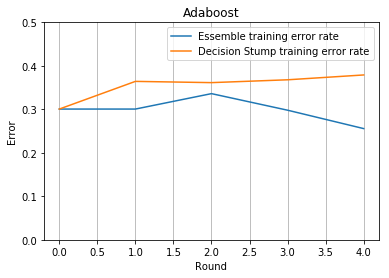

In [12]:
experiment(5)

ACC 77.87% (std +/- 4.35%)


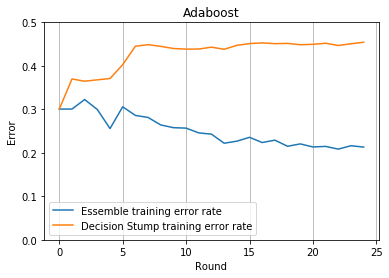

In [13]:
experiment(25)

ACC 81.21% (std +/- 2.05%)


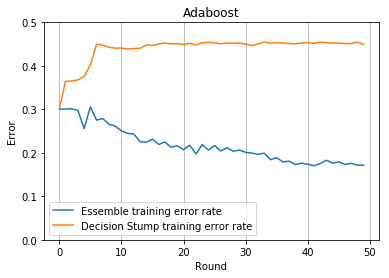

In [14]:
experiment(50)

ACC 89.56% (std +/- 2.80%)


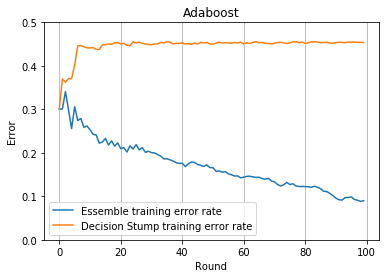

In [15]:
experiment(100)

ACC 98.02% (std +/- 0.61%)


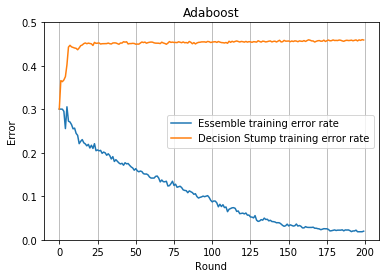

In [16]:
experiment(200)

ACC 98.23% (std +/- 0.78%)


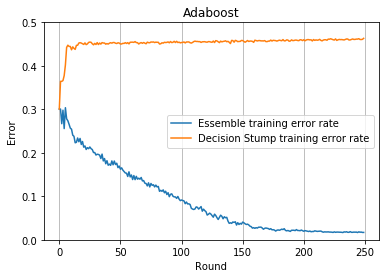

In [18]:
experiment(250)

ACC 98.33% (std +/- 1.02%)


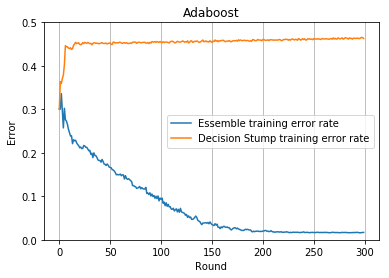

In [19]:
experiment(300)

Os experimentos demonstram que a medida que vão ocorrendo mais iterações o erro do stump selecionado a cada iteração aumenta. Isto ocorre devido ao algoritmo ter sido implementado de forma que os melhores stumps vão sendo escolhidos primeiro. Além disto a atualização de pesos faz com que seja difícil a escolha de um mesmo stump.

Pode-se observar que ao ser adicionado mais classificadores fracos a acurácia do modelo aumentada. Foram necessárias aproximadamente 250 iterações para que o erro de treinamento fosse minimizado.